In [34]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
%matplotlib inline

In [35]:
class Body:
    def __init__(self, name, mass, position, velocity, has_units=True):
        self.name = name
        self.has_units = has_units
        
        if self.has_units:
            self.mass = mass.cgs
            self.position = position.cgs.value
            self.velocity = velocity.cgs.value
        else:
            self.mass = mass
            self.position = position
            self.velocity = velocity
    
    # Объединенный вектор позиции и скорости тела
    def getY():
        return np.concatenate((self.position, self.velocity))
    
    def getMass():
        if self.has_units:
            return self.mass.cgs.value
        else:
            return self.mass
    

In [36]:
class Simulation():
    def __init__(self, bodies, has_units=True):  
        self.has_units = has_units
        self.bodies = bodies
        self.bodies_len = len(self.bodies)
        self.nDim = 6.0
        self.quant_vec = np.concatenate(np.array([i.getY() for i in self.bodies]))
        self.mass_vec = np.array([i.getMass() for i in self.bodies])
    
    def set_diff_eq(self, calc_diff_eqs, **kwargs):
        self.diff_eq_kwargs = kwargs
        self.calc_diff_eqs = calc_diff_eqs
    
    def rk4(self,t,dt):
        k1 = dt * self.calc_diff_eqs(t,self.quant_vec,self.mass_vec,**self.diff_eq_kwargs) 
        k2 = dt * self.calc_diff_eqs(t + 0.5*dt,self.quant_vec+0.5*k1,self.mass_vec,**self.diff_eq_kwargs)
        k3 = dt * self.calc_diff_eqs(t + 0.5*dt,self.quant_vec+0.5*k2,self.mass_vec,**self.diff_eq_kwargs)
        k4 = dt * self.calc_diff_eqs(t + dt,self.quant_vec + k2,self.mass_vec,**self.diff_eq_kwargs)

        y_new = self.quant_vec + ((k1 + 2*k2 + 2*k3 + k4) / 6.0)

        return y_new
    
    def run(self,T,dt,t0=0):
        '''
        Method which runs the simulation on a given set of bodies.
        ---------------------
        Params: 
            T: total time (in simulation units) to run the simulation. Can have units or not, just set has_units appropriately.
            dt: timestep (in simulation units) to advance the simulation. Same as above
            t0 (optional): set a non-zero start time to the simulation.

        Returns: 
            None, but leaves an attribute history accessed via 
            'simulation.history' which contains all y vectors for the simulation. 
            These are of shape (Nstep,Nbodies * 6), so the x and y positions of particle 1 are
            simulation.history[:,0], simulation.history[:,1], while the same for particle 2 are
            simulation.history[:,6], simulation.history[:,7]. Velocities are also extractable.
        '''
        if self.has_units:
            try:
                _ = t0.unit
            except:
                t0=(t0*T.unit).cgs.value
            T = T.cgs.value
            dt = dt.cgs.value

        self.history = [self.quant_vec]
        clock_time = t0
        nsteps = int((T - t0)/dt)
        start_time = time.time()
        for step in range(nsteps):
            sys.stdout.flush()
            sys.stdout.write('Integrating: step = {} / {} | simulation time = {}'.format(step,nsteps,round(clock_time,3)) + '\r')
            y_new = self.rk4(0,dt)
            self.history.append(y_new)
            self.quant_vec = y_new
            clock_time += dt
        runtime = time.time() - start_time
        print('\n')
        print('Simulation completed in {} seconds'.format(runtime))
        self.history = np.array(self.history)
        
    
    

In [37]:
def createVector(x=0, y=0, z=0):
    return np.array([x, y, z], float)

def nbody_solve(t,y,masses):
    N_bodies = int(len(y) / 6)
    solved_vector = np.zeros(y.size)
    for i in range(N_bodies):
        ioffset = i * 6 
        for j in range(N_bodies):
            joffset = j*6
            solved_vector[ioffset] = y[ioffset+3]
            solved_vector[ioffset+1] = y[ioffset+4]
            solved_vector[ioffset+2] = y[ioffset+5]
            if i != j:
                dx = y[ioffset] - y[joffset]
                dy = y[ioffset+1] - y[joffset+1]
                dz = y[ioffset+2] - y[joffset+2] 
                r = (dx**2+dy**2+dz**2)**0.5
                ax = (-c.G.cgs * masses[j] / r**3) * dx
                ay = (-c.G.cgs * masses[j] / r**3) * dy
                az = (-c.G.cgs * masses[j] / r**3) * dz
                ax = ax.value
                ay = ay.value
                az = az.value
                solved_vector[ioffset+3] += ax
                solved_vector[ioffset+4] += ay
                solved_vector[ioffset+5] += az            
    return solved_vector 

In [39]:
M_moon = (7.347e22*u.kg).cgs
v_moon = np.array([0,1.022,0])*u.km/u.s
moon_momentum = M_moon * v_moon

Moon = Body(mass=M_moon,
           position = np.array([3.84e5,0,0])*u.km,
           velocity = v_moon,
           name='Moon')

#calculate reciprocal momentum for Earth
v_earth = - (moon_momentum / c.M_earth).to(u.km/u.s).value

Earth = Body(mass=c.M_earth.cgs,
             position=np.array([0,0,0])*u.km,
             velocity=np.array(v_earth)*u.km/u.s,
             name='Earth')


bodies = [Earth,Moon]

simulation = Simulation(bodies)
simulation.set_diff_eq(nbody_solve)

simulation.run(72*u.day,1*u.hr)

TypeError: getY() takes 0 positional arguments but 1 was given

In [24]:
def derivative_r(velocity):
    return velocity

def derivative_v(position, index):
    value = 0.0
    
    for i in range(len(bodies)):
        if i != index:
            value += G * bodies[i].mass * (bodies[i].position - position) / np.linalg.norm((bodies[i].position - position) ** 3)
    
    return value

In [19]:
while t <= T:
    BODIES_STATES.append(copy.deepcopy(bodies))
    
    for i in range(len(bodies)):
        k1_r = derivative_r(bodies[i].velocity)
        k1_v = derivative_v(bodies[i].position, i)

        k2_r = derivative_r(bodies[i].velocity + h * k1_v / 2)
        k2_v = derivative_v(bodies[i].position + h * k1_r / 2, i)

        k3_r = derivative_r(bodies[i].velocity + h * k2_v / 2)
        k3_v = derivative_v(bodies[i].position + h * k2_r / 2, i)

        k4_r = derivative_r(bodies[i].velocity + h * k3_v)
        k4_v = derivative_v(bodies[i].position + h * k3_r, i)
        
        bodies[i].position += h * (k1_r + 2 * k2_r + 2 * k3_r + k4_r) / 6
        bodies[i].velocity += h * (k1_v + 2 * k2_v + 2 * k3_v + k4_v) / 6
        
    t += h

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

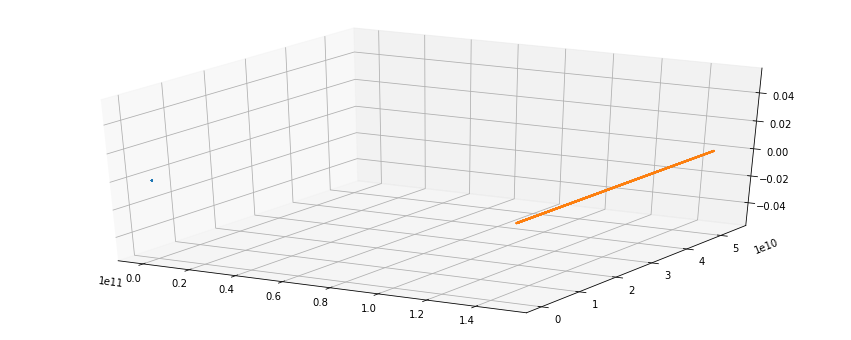

In [341]:
fig = plt.figure(figsize=[15, 6])
ax = fig.add_subplot(111, projection='3d')
    
for j in range(len(bodies)):
    ax.scatter([b[j].position[0] for b in BODIES_STATES],
               [b[j].position[1] for b in BODIES_STATES],
               [b[j].position[2] for b in BODIES_STATES], s=1)